In [2]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

In [3]:


# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# Use site: http://optionsforum.net/topic/268/50-stocks-with-most-liquid-options
'''
tickers = ['ABT', 'ABBV', 'PNR', 'CL', 'HRL', 'CLX', 'LOW', 'PG', 'BCR', 'PEP', 'CTAS',
          'XOM', 'EMR', 'PPG', 'GWW', 'ADM', 'TGT', 'AFL', 'ED', 'MMM', 'SHW', 'CVX',
          'WBA', 'SPGI', 'JNJ', 'DOV', 'KO', 'SWK', 'CAH', 'MCD', 'APD', 'FRT', 'VFC',
          'KMB', 'WMT', 'BDX', 'GPC', 'ADP', 'LEG', 'TROW', 'ECL', 'CINF', 'MDT', 'MKC',
          'ITW', 'BEN', 'NUE', 'SYY', 'T', 'GD']
'''
tickers = pd.read_csv('feb19list.csv')
tickers = list(tickers['Ticker'])
#tickers = ['TSN','JD']
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2007-01-01'
end_date = '2018-02-09'

start = dt.datetime(2007, 1, 1)
end = dt.datetime.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start, end)

# panel_data.minor_xs('SPY')

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between start_date and end_date
#all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [4]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window, hist_window,ticker):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0], rot=20)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.tail(plot_window).index)
    # Every ith ticklable shows the month and day
    i = int(plot_window/10)
    ticklabels[::i] = [item.strftime('%b %d %Y') for item in df.tail(plot_window).index[::i]]
    # Every jth ticklabel includes the year
    j = i
    ticklabels[::j] = [item.strftime('%b %d\n%Y') for item in df.tail(plot_window).index[::j]]
    #axes[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter(ticklabels))
    axes[0,0].set_xlabel('')
    axes[0,0].set_xticklabels(ticklabels)
    
    df.tail(hist_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(hist_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(hist_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    
    axes[0,0].set_title('Period Price Deviations')
    axes[0,1].set_title('Distribution of Price Deviations')
    axes[1,0].set_title('Left-Side Distribution')
    axes[1,1].set_title('Right-Side Distribution')
    fig.suptitle(ticker,fontsize=20)
    print(df.tail(5))
    return df

In [5]:
def vol_summary(adj_c_df,rolling_period,lookback_window,hist_window,ticker):
    etf = price_devs(adj_c_df,rolling_period,lookback_window,hist_window,ticker)
    
    # Describing Deviation Data
    obs = hist_window

    #print(etf.price_dev.tail(obs).describe())#percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[0]}
    df = pd.DataFrame(d,index = d['Std Bins'])[['Frequency']]
    #print(df)
    return df, etf

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Fang\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-02-12  63.220001     -1.150002    -0.018027   0.022629          1.430594   
2018-02-13  64.730003      1.510002     0.023604   0.026559          1.719160   
2018-02-14  67.940002      3.209999     0.048400   0.027663          1.879403   
2018-02-15  70.000000      2.059998     0.029870   0.028044          1.963053   
2018-02-16  69.769997     -0.230003    -0.003291   0.021394          1.492667   

            price_dev  annual_vol  
Date                               
2018-02-12  -0.583614    0.359221  
2018-02-13   1.055507    0.421610  
2018-02-14   1.867190    0.439132  
2018-02-15   1.096092    0.445179  
2018-02-16  -0.117166    0.339621  
---------------------
Date of largest drop
-13.2746643583
2017-03-20 00:00:00
---------------------
Date of largest spike
9.56101105389
2016-11-10 00:00:00
---------------------
  

               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-02-12  33.200001     -0.229999    -0.006904   0.014992          0.497741   
2018-02-13  33.130001     -0.070000    -0.002111   0.015623          0.517581   
2018-02-14  34.439999      1.309998     0.038779   0.021361          0.735674   
2018-02-15  35.000000      0.560001     0.016129   0.020733          0.725647   
2018-02-16  34.470001     -0.529999    -0.015259   0.023445          0.808143   

            price_dev  annual_vol  
Date                               
2018-02-12  -0.352782    0.237994  
2018-02-13  -0.140635    0.248003  
2018-02-14   2.530999    0.339096  
2018-02-15   0.761208    0.329123  
2018-02-16  -0.730381    0.372175  
---------------------
Date of largest drop
-9.44500545705
2017-10-02 00:00:00
---------------------
Date of largest spike
17.3707971181
2016-09-01 00:00:00
---------------------
  

               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-02-12  44.730000      0.230000     0.005155   0.017285          0.773175   
2018-02-13  45.259998      0.529998     0.011779   0.019562          0.885373   
2018-02-14  46.779999      1.520001     0.033032   0.013675          0.639711   
2018-02-15  46.810001      0.030002     0.000641   0.014336          0.671075   
2018-02-16  46.400002     -0.409999    -0.008797   0.017998          0.835104   

            price_dev  annual_vol  
Date                               
2018-02-12   0.188666    0.274397  
2018-02-13   0.685483    0.310536  
2018-02-14   1.716792    0.217082  
2018-02-15   0.046899    0.227579  
2018-02-16  -0.610959    0.285708  
---------------------
Date of largest drop
-26.1342229186
2016-09-01 00:00:00
---------------------
Date of largest spike
14.0277355064
2016-11-09 00:00:00
---------------------
  

C:\Users\Fang\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


            prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                         
2018-02-12    4.65          0.06     0.012987   0.024271          0.112858   
2018-02-13    4.82          0.17     0.035907   0.033617          0.162036   
2018-02-14    4.90          0.08     0.016461   0.020100          0.098489   
2018-02-15    5.05          0.15     0.030153   0.010919          0.055142   
2018-02-16    5.16          0.11     0.021548   0.008683          0.044805   

            price_dev  annual_vol  
Date                               
2018-02-12   0.684684    0.385283  
2018-02-13   1.506316    0.533659  
2018-02-14   0.493719    0.319073  
2018-02-15   1.523017    0.173336  
2018-02-16   1.994861    0.137842  
---------------------
Date of largest drop
-46.6081591449
2017-11-03 00:00:00
---------------------
Date of largest spike
15.2615163039
2016-11-11 00:00:00
---------------------
               prices  

               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2018-02-12  33.070000      0.259999     0.007893   0.014653          0.484587   
2018-02-13  33.080002      0.010002     0.000302   0.014637          0.484188   
2018-02-14  34.040001      0.959999     0.028607   0.012356          0.420600   
2018-02-15  34.080002      0.040001     0.001174   0.013186          0.449368   
2018-02-16  34.349998      0.269996     0.007891   0.013186          0.452930   

            price_dev  annual_vol  
Date                               
2018-02-12   0.541807    0.232615  
2018-02-13   0.020640    0.232353  
2018-02-14   1.982698    0.196146  
2018-02-15   0.095105    0.209316  
2018-02-16   0.600835    0.209317  
---------------------
Date of largest drop
-9.94204409095
2017-06-16 00:00:00
---------------------
Date of largest spike
7.98312656877
2016-06-16 00:00:00
---------------------
  

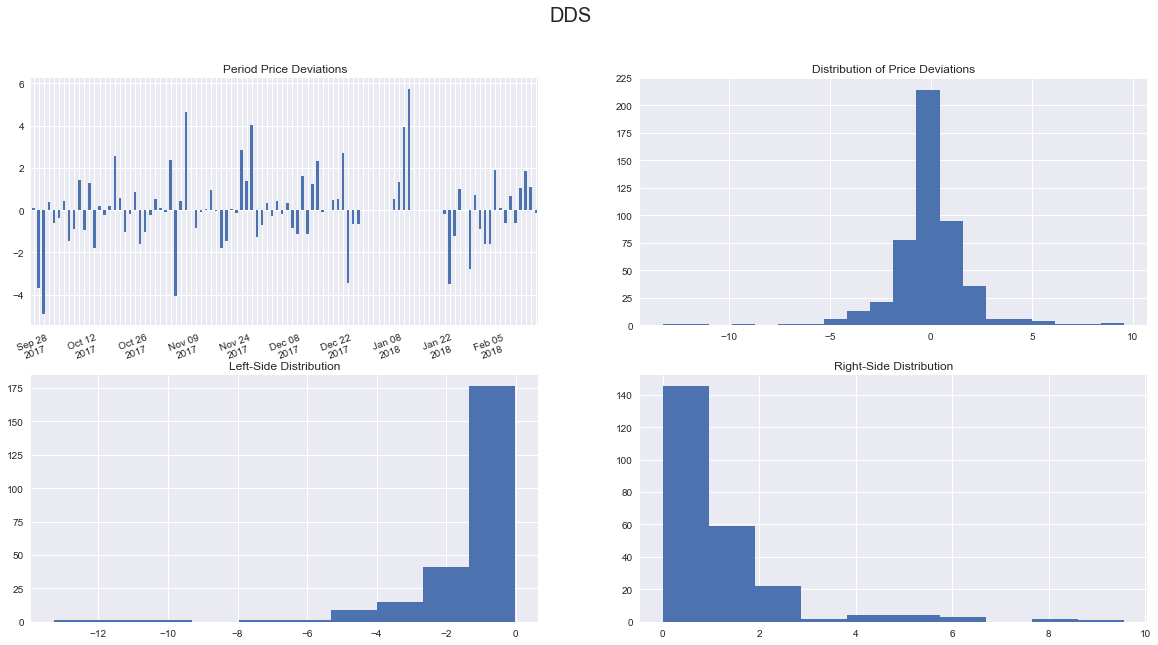

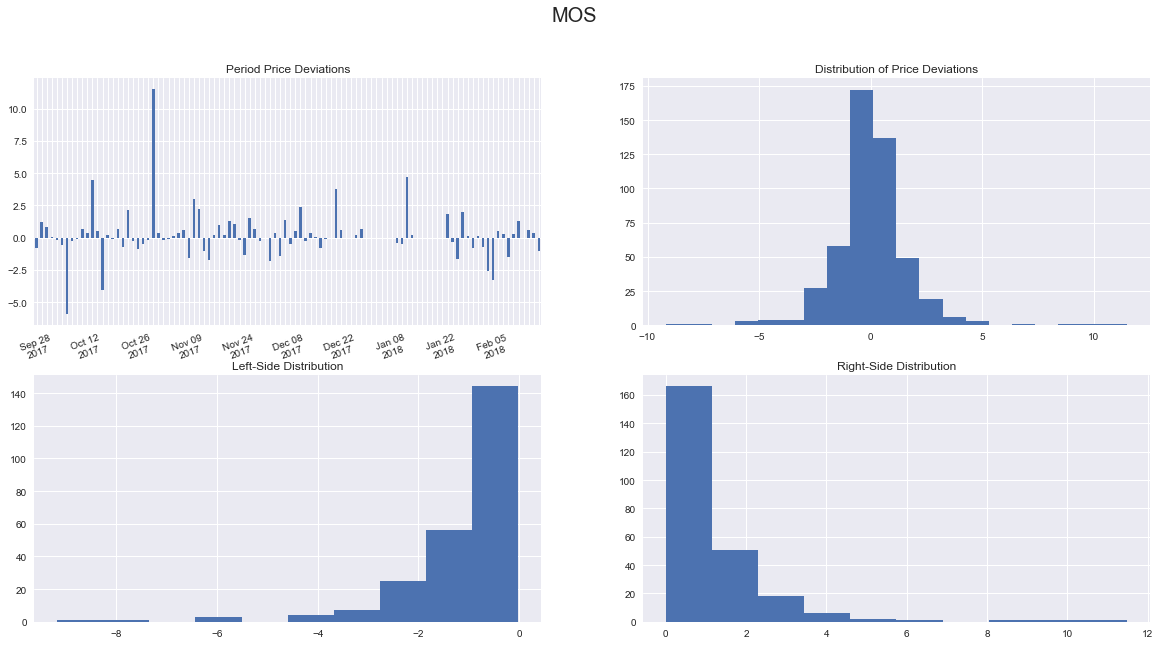

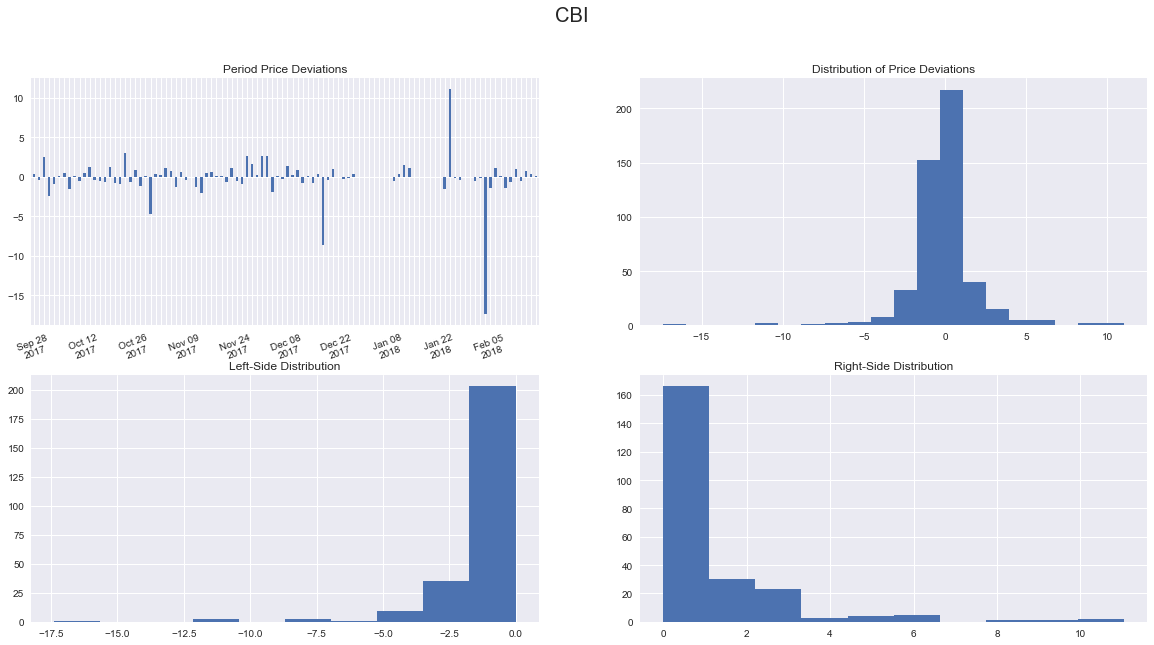

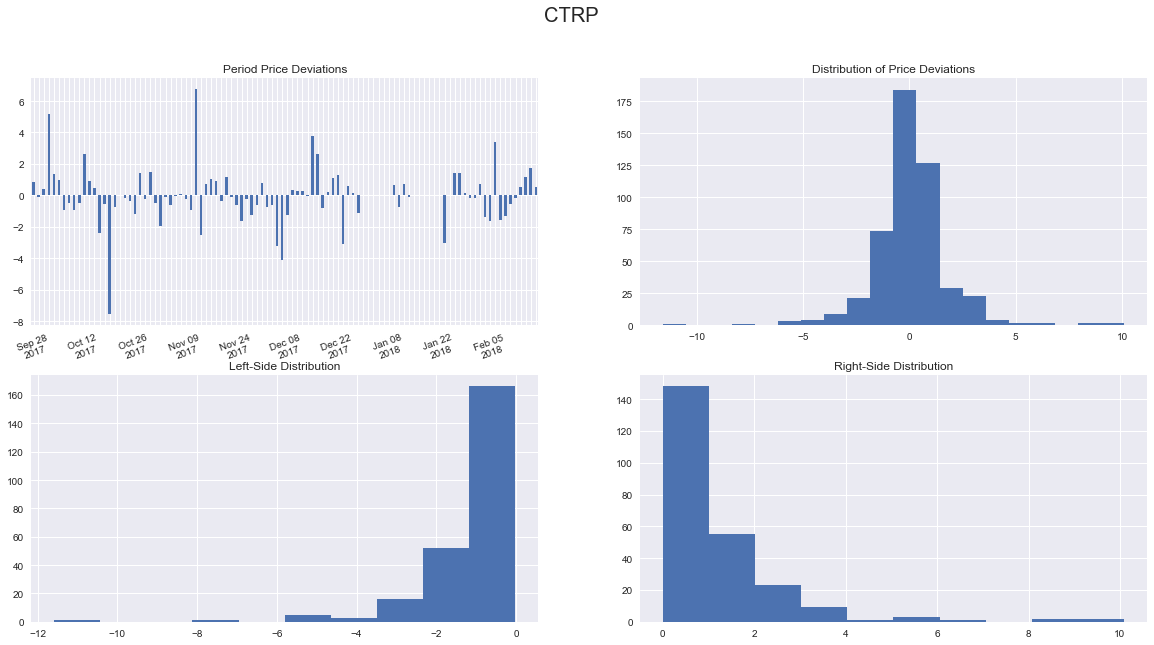

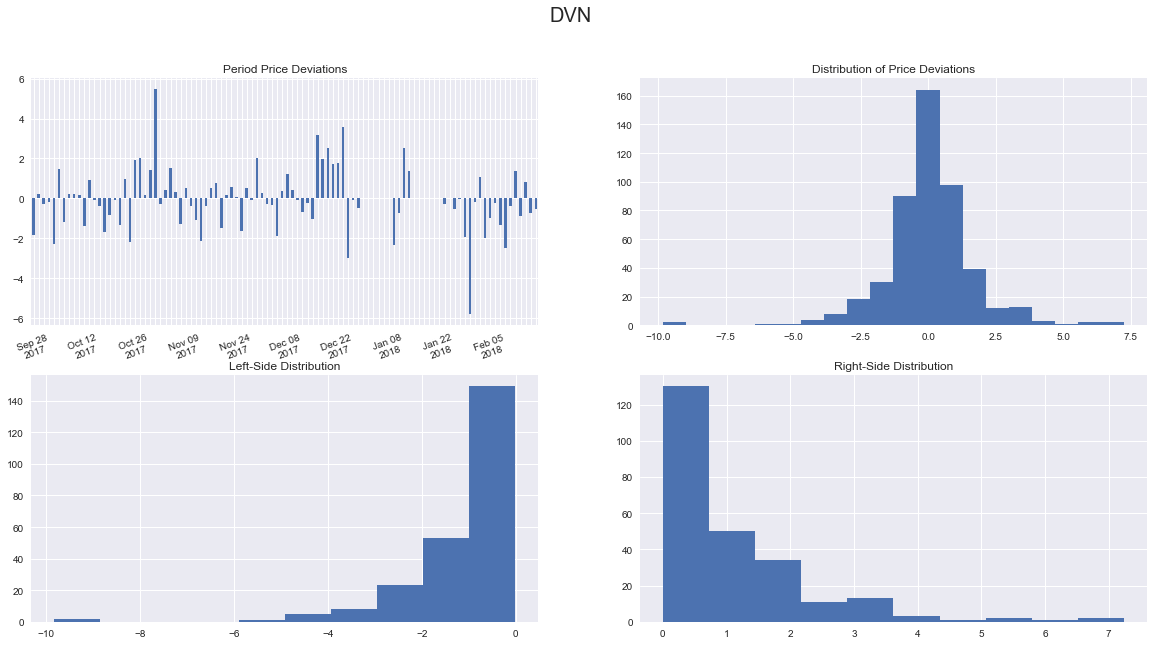

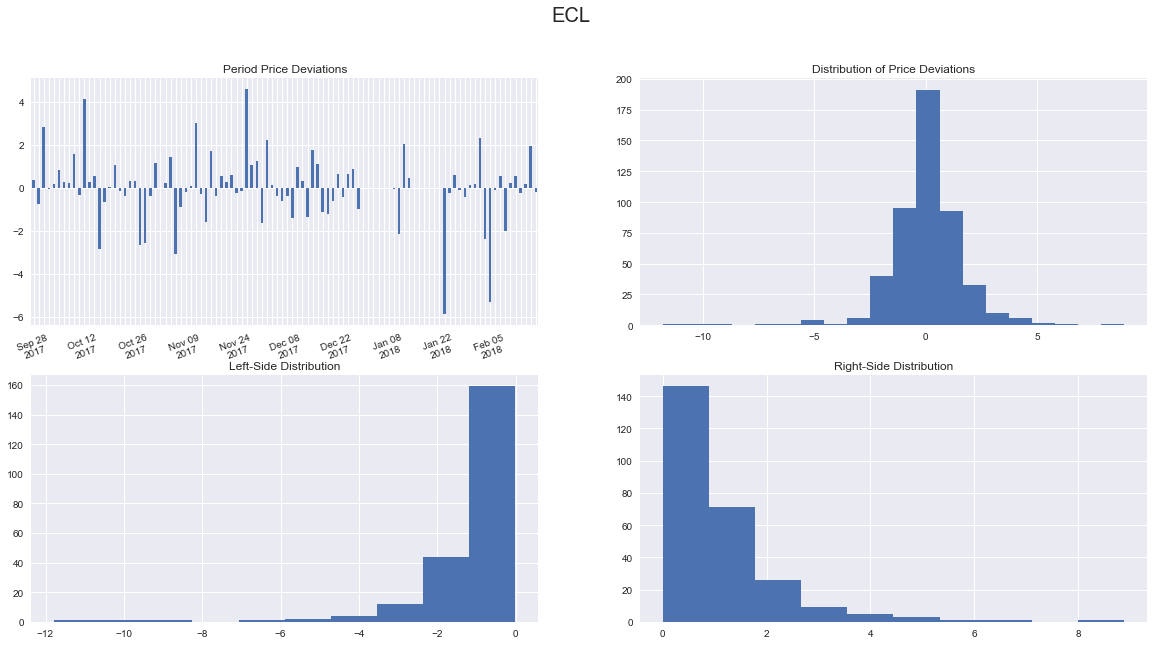

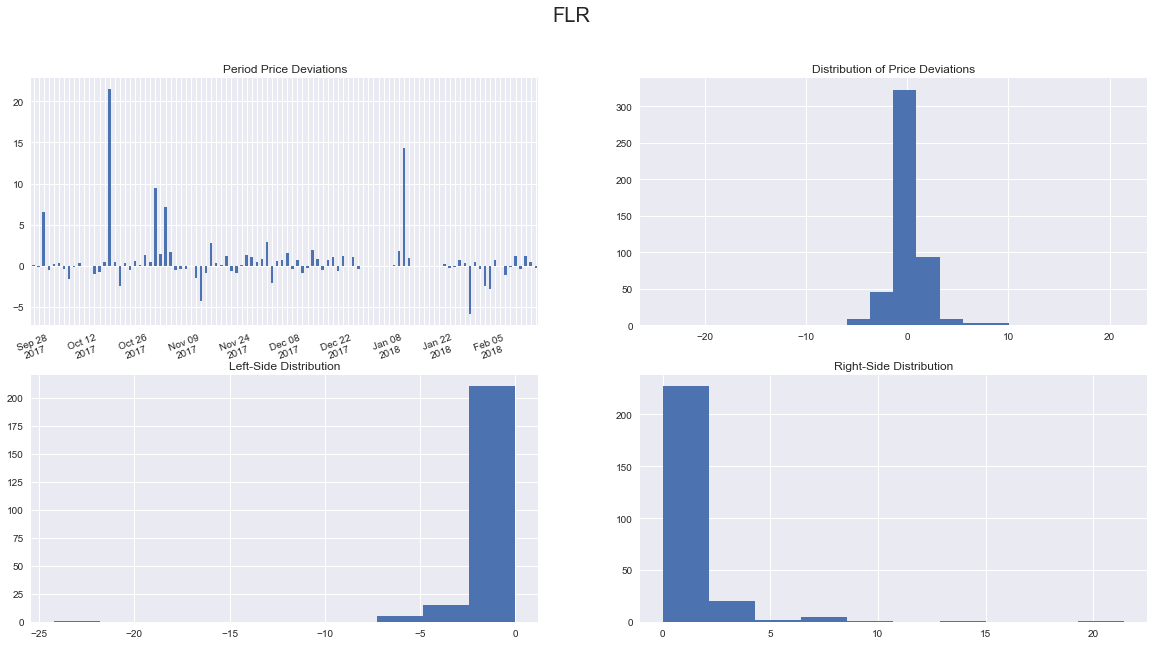

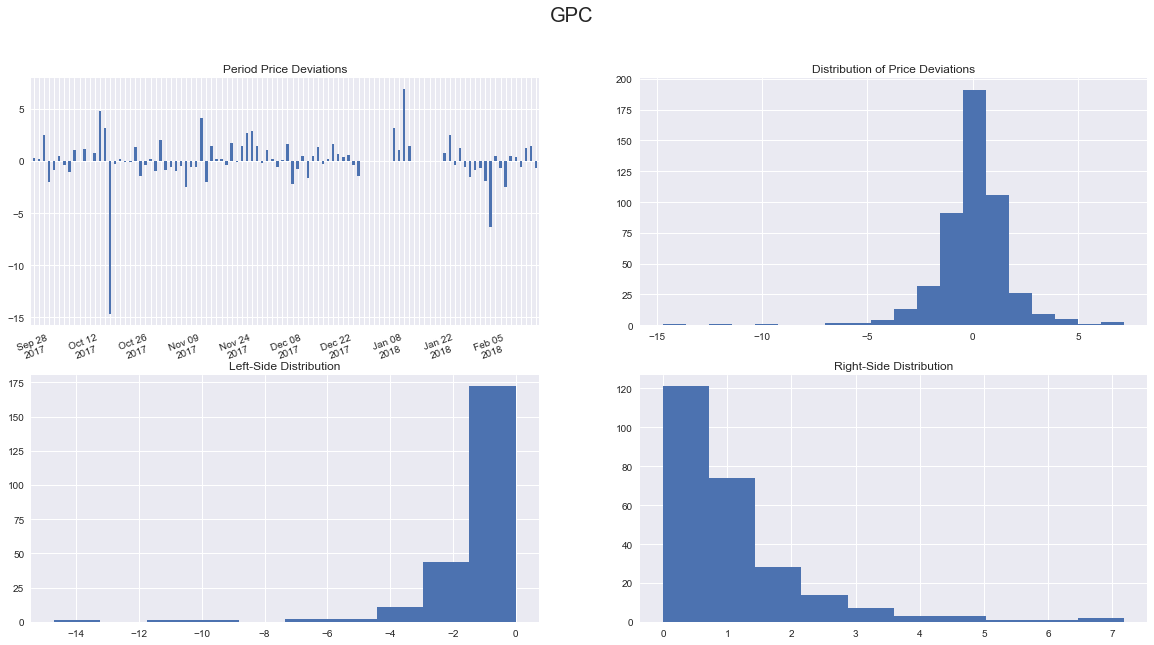

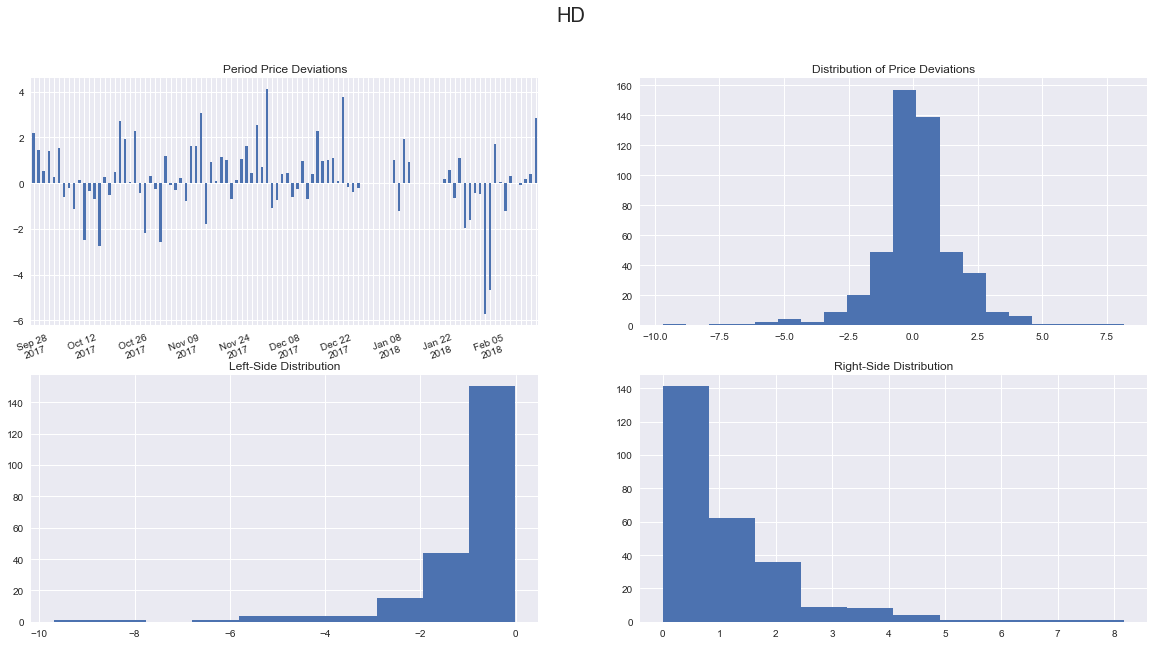

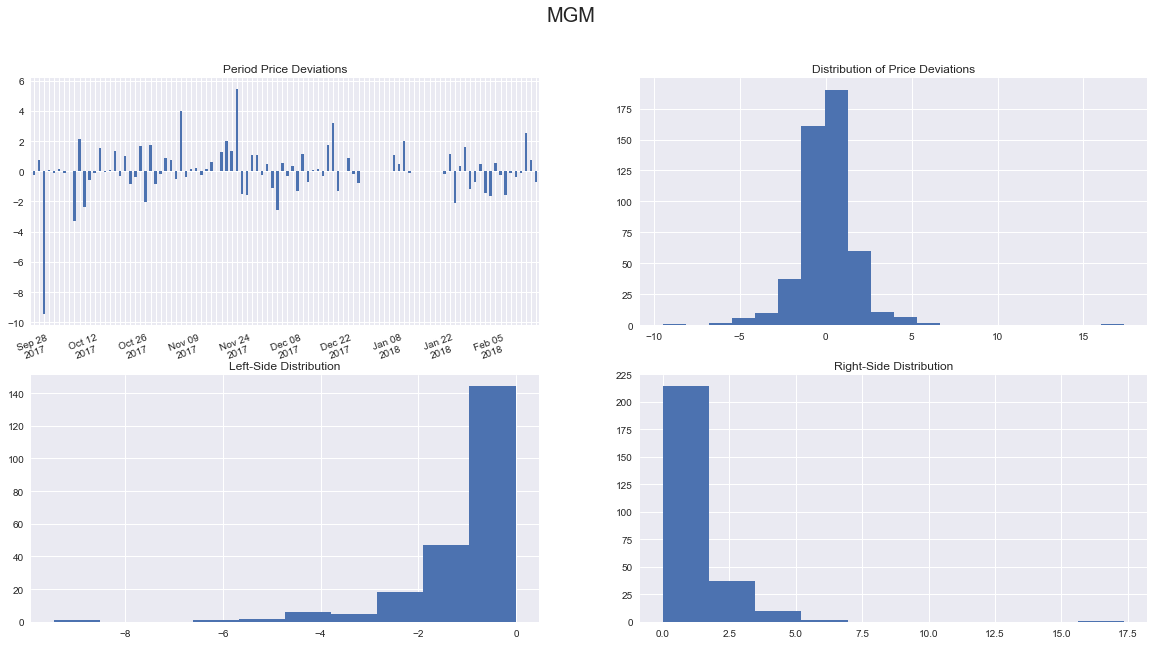

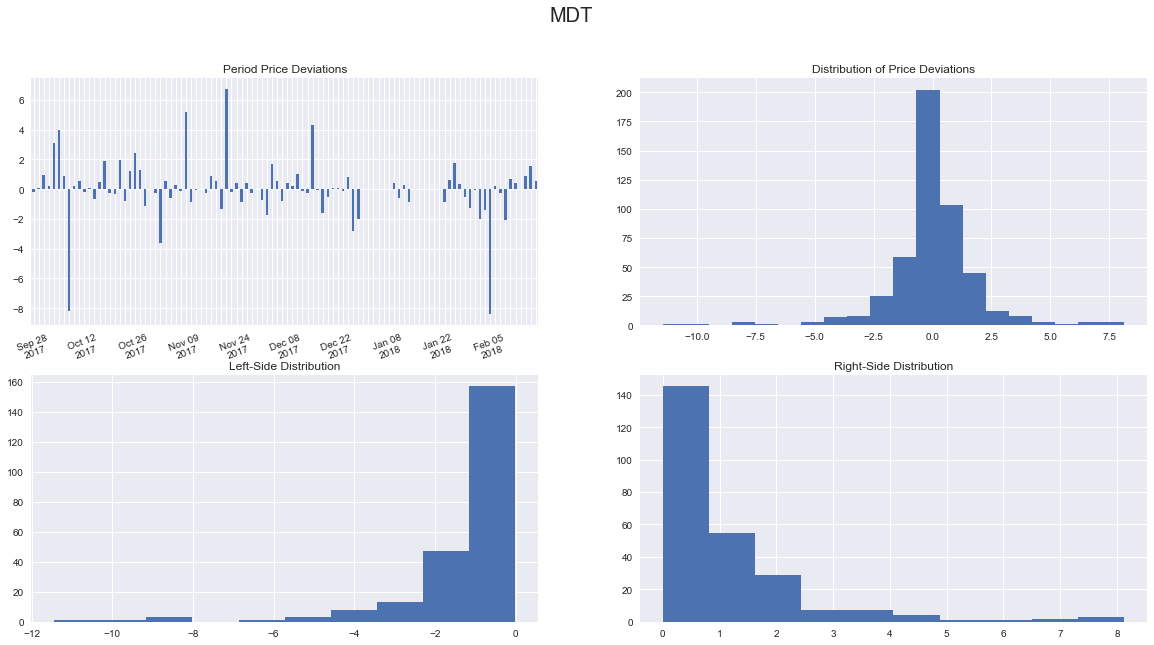

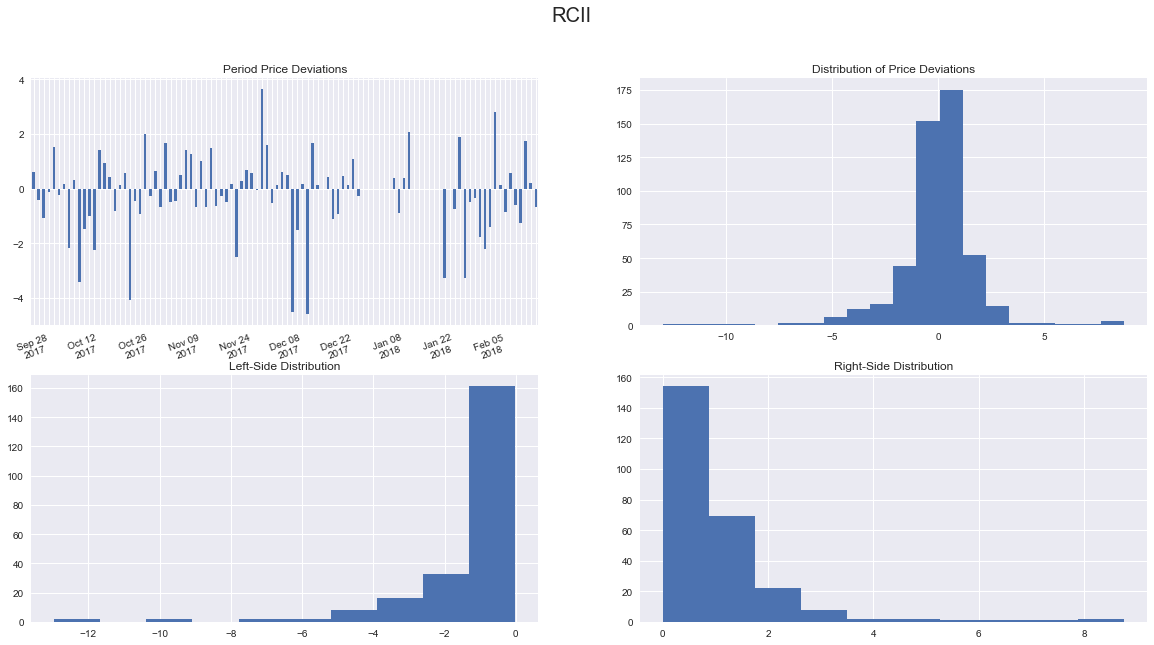

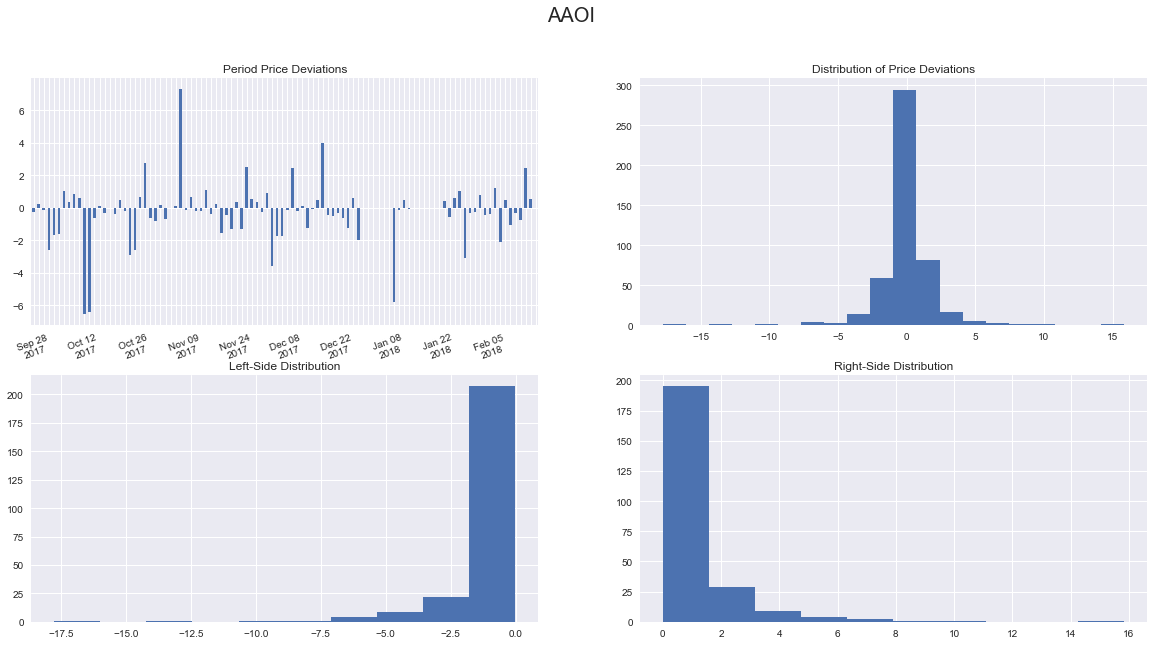

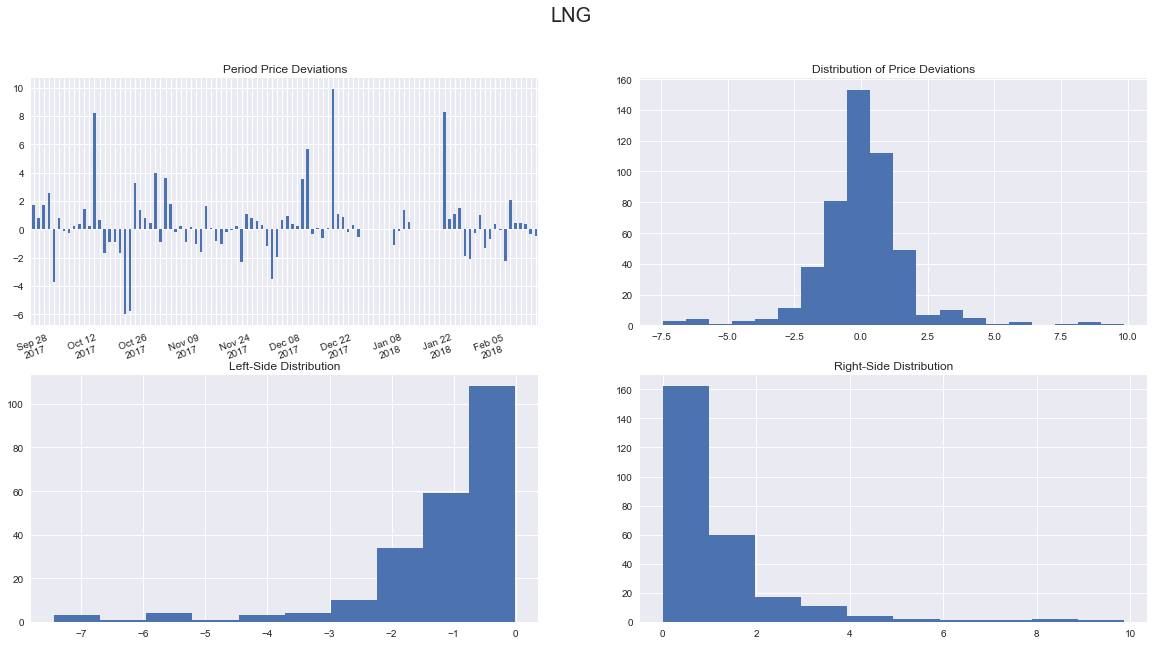

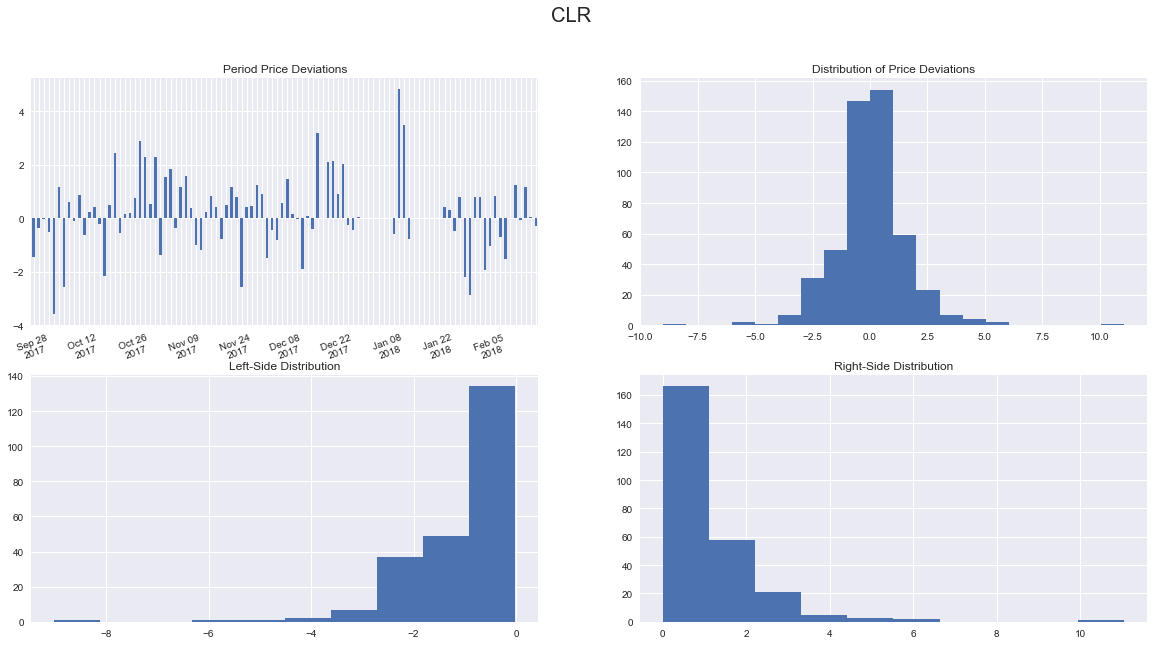

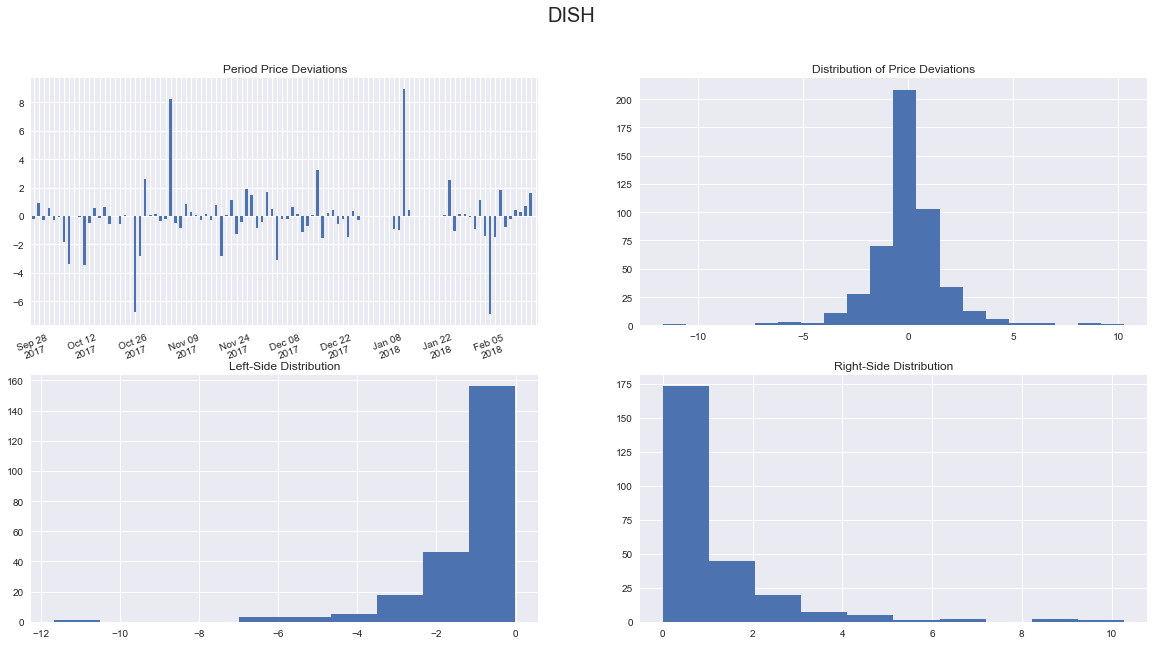

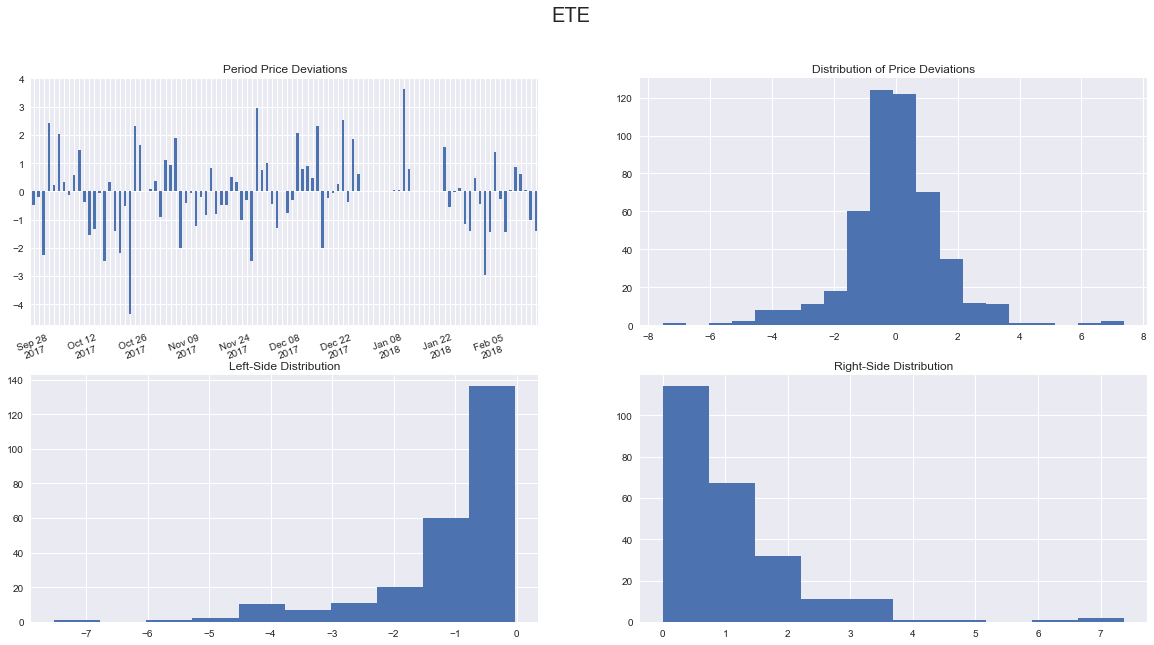

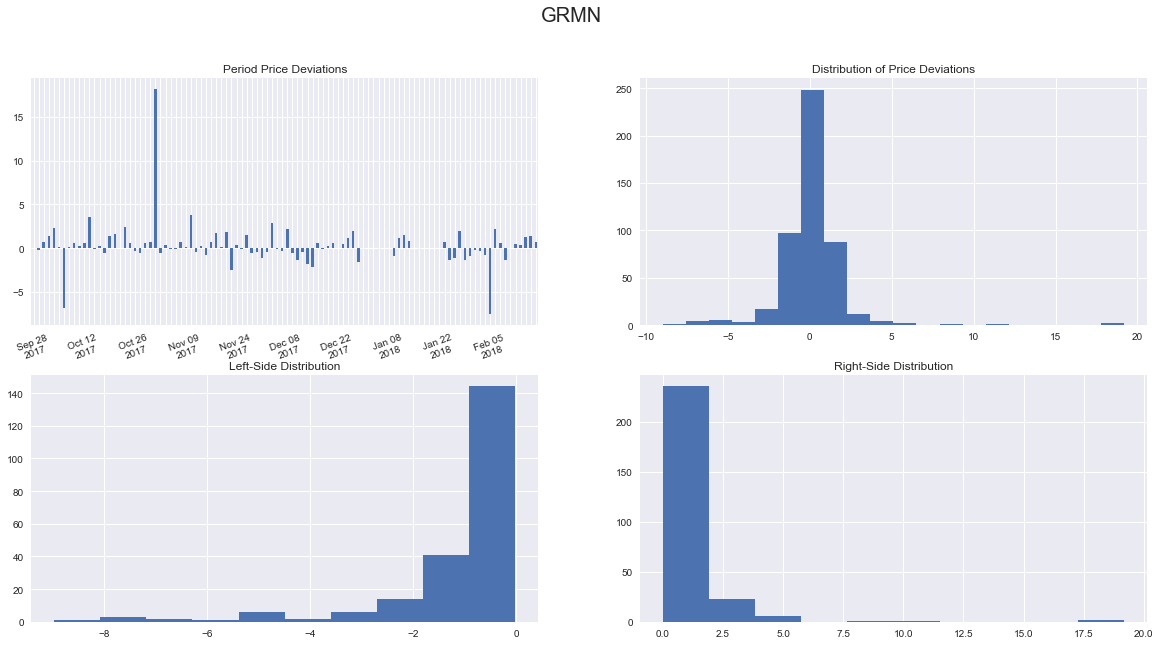

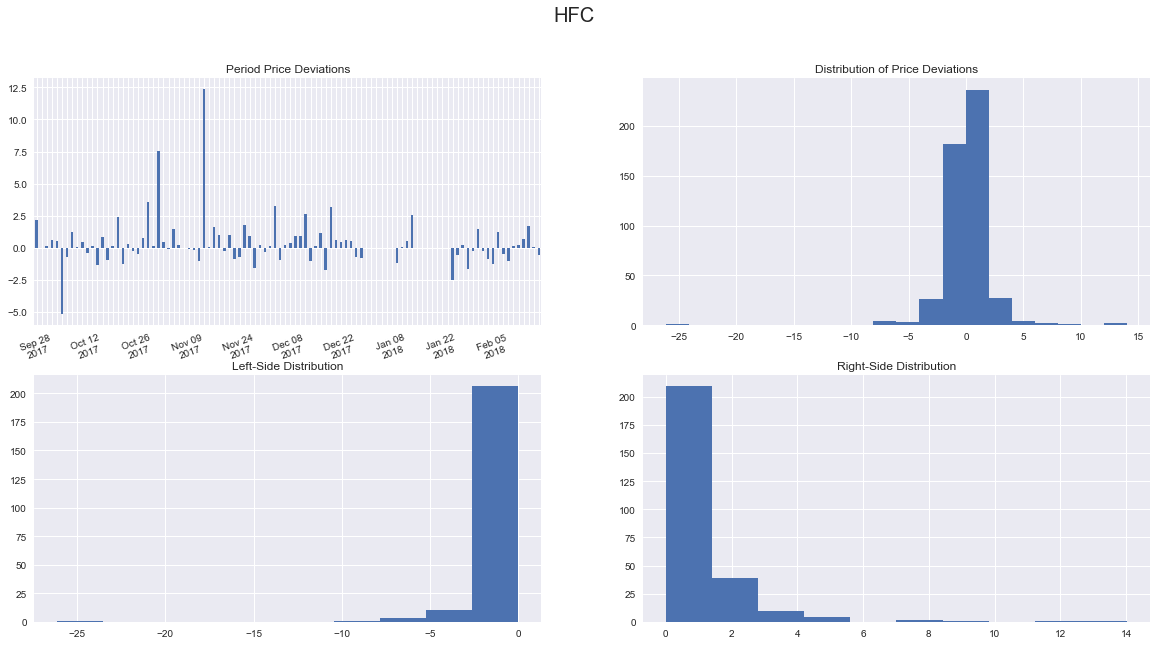

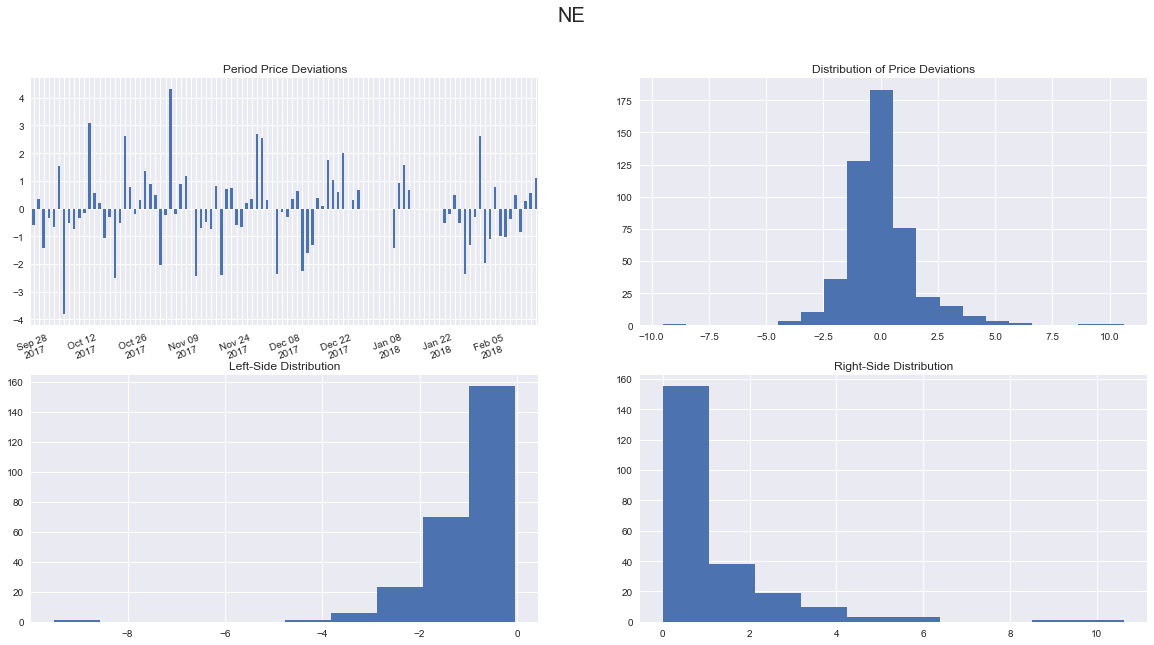

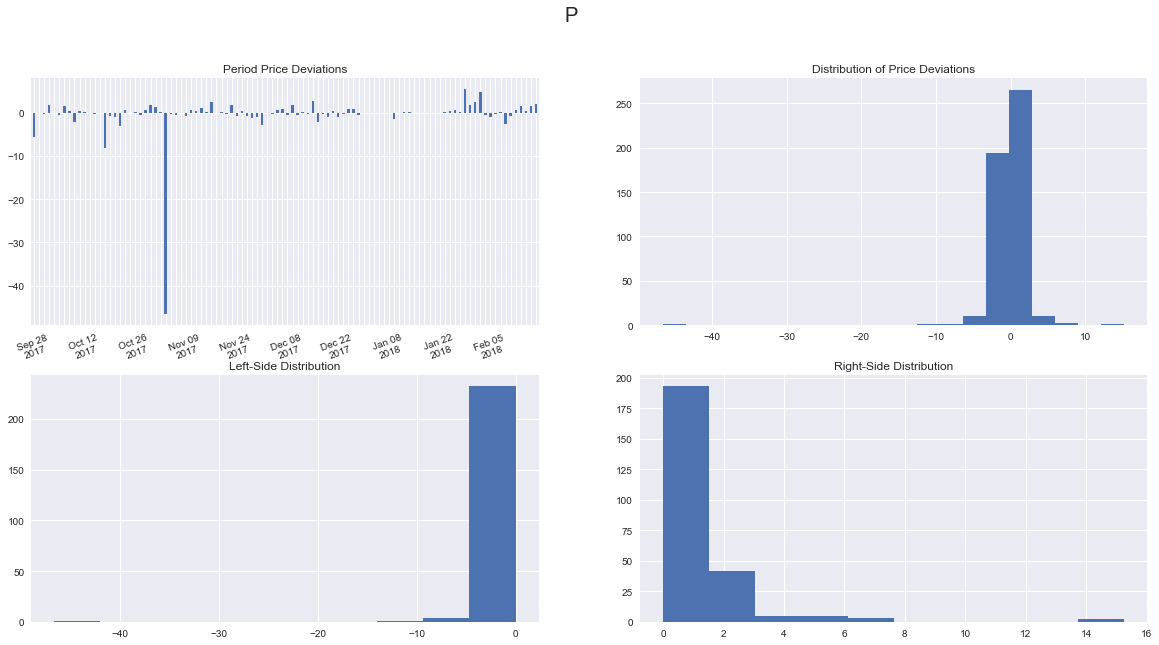

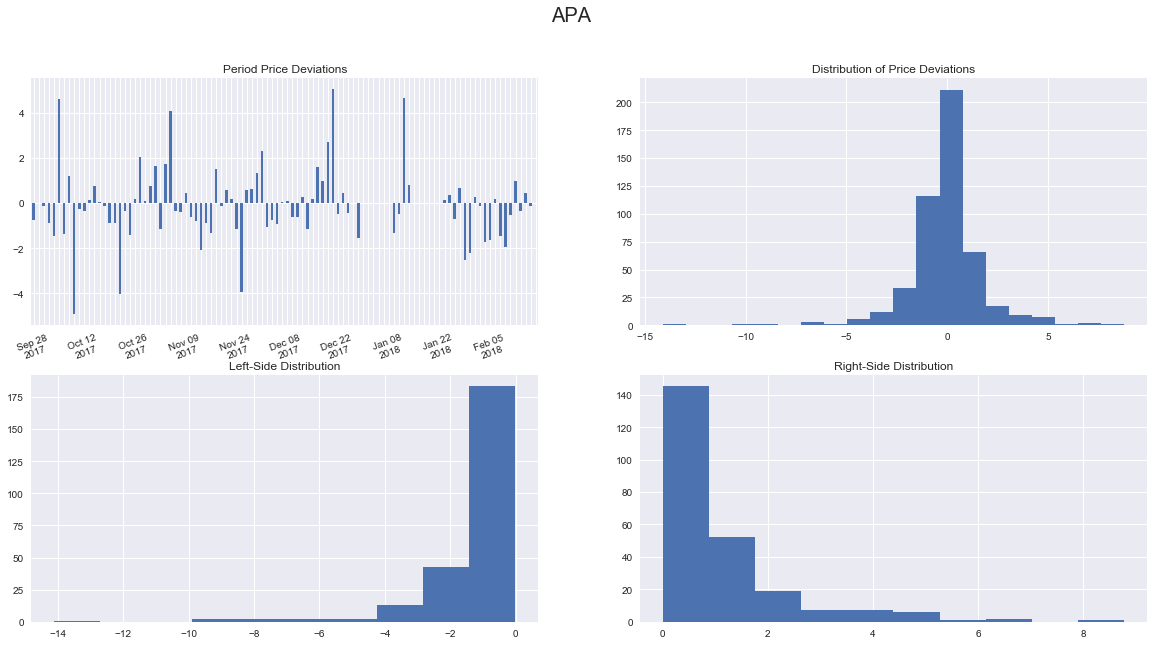

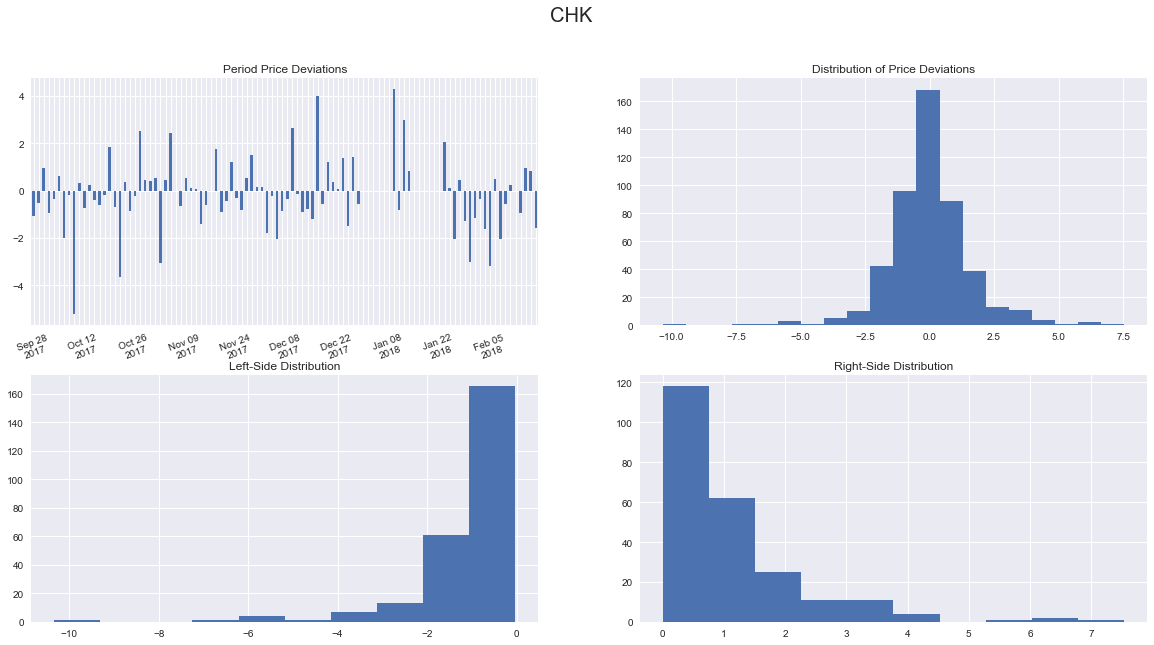

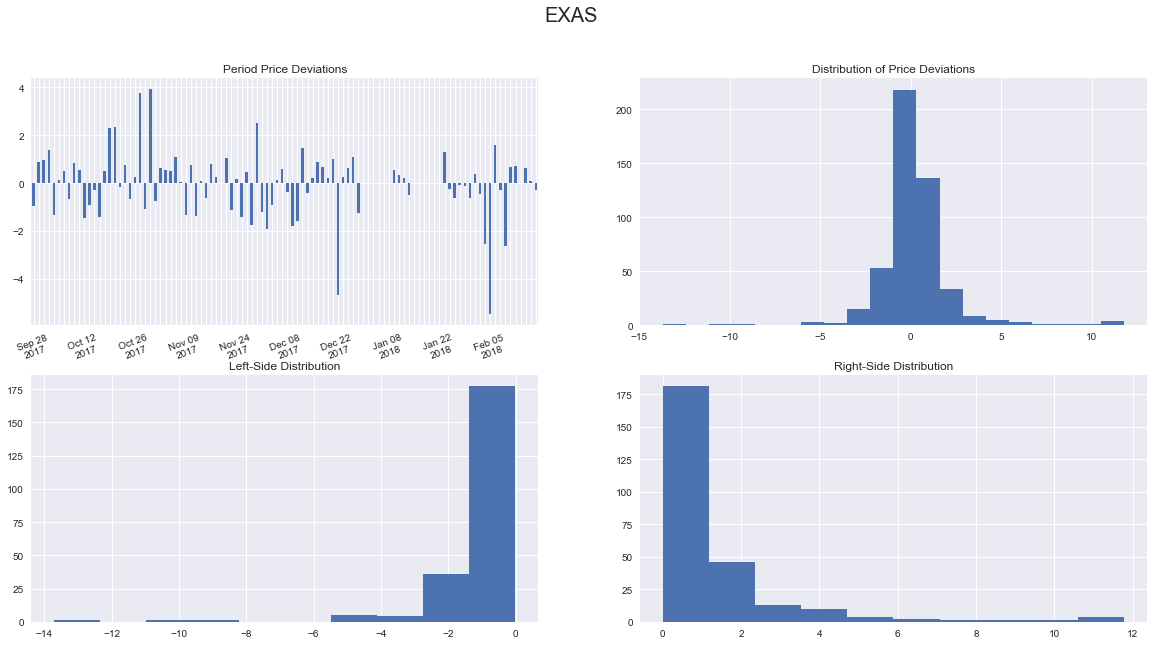

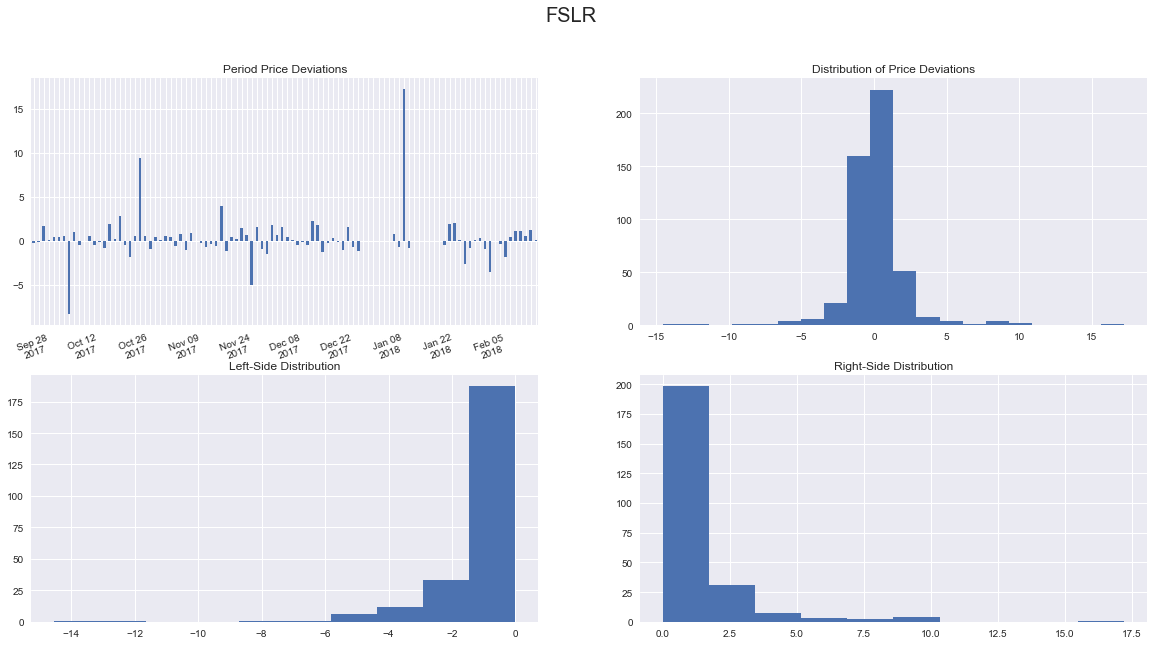

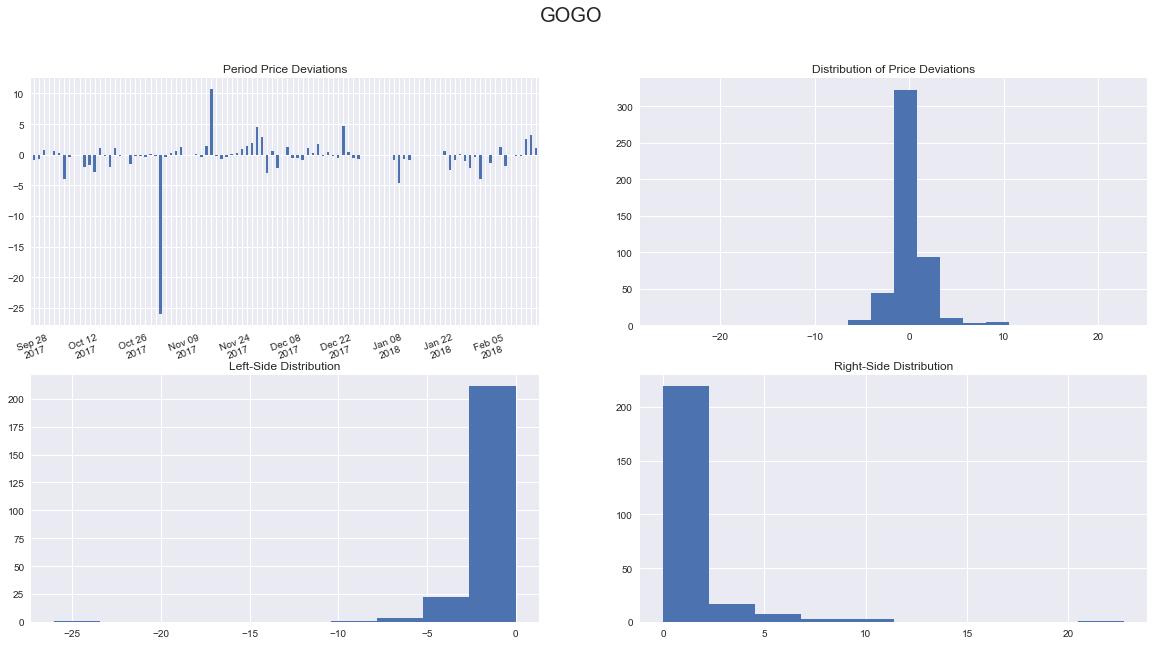

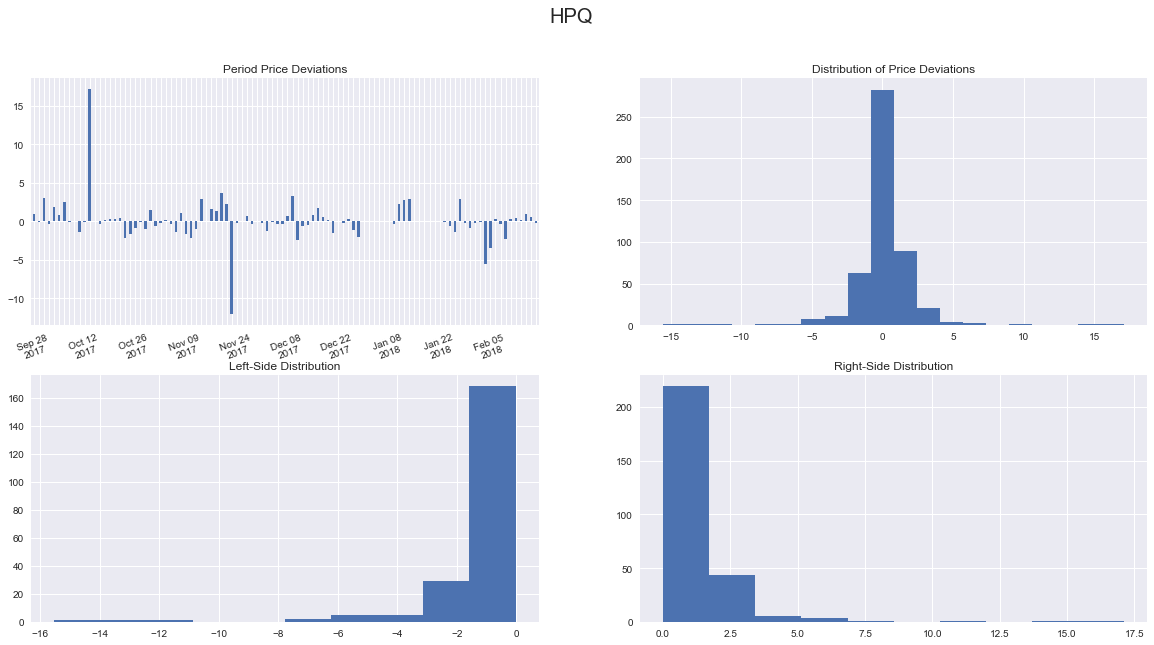

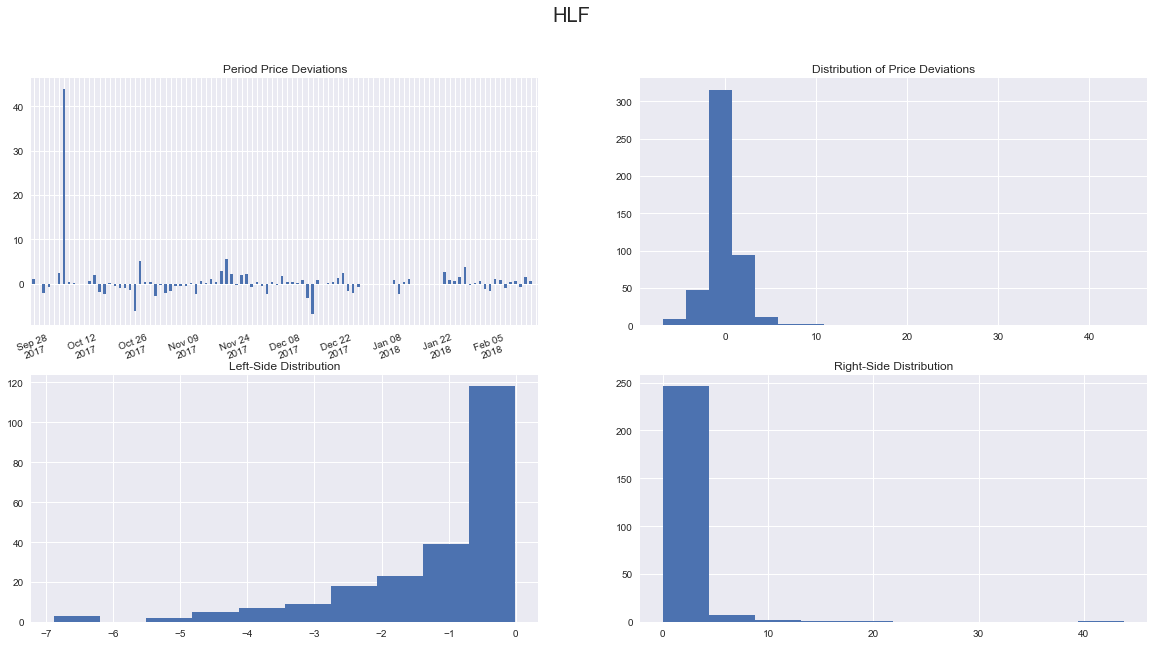

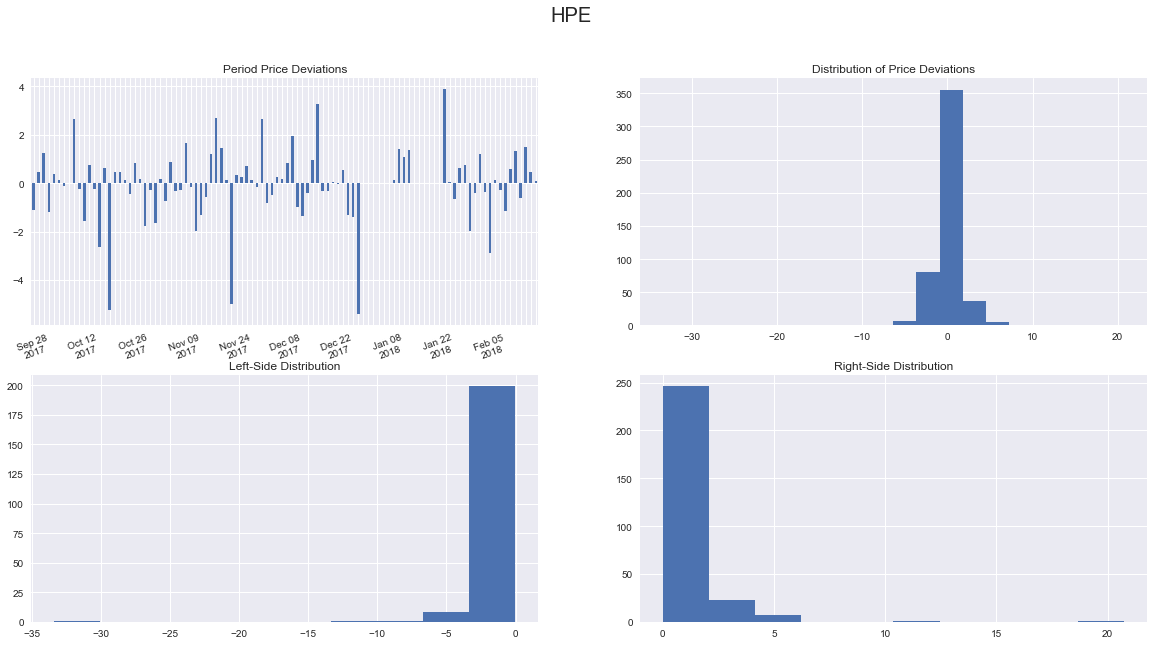

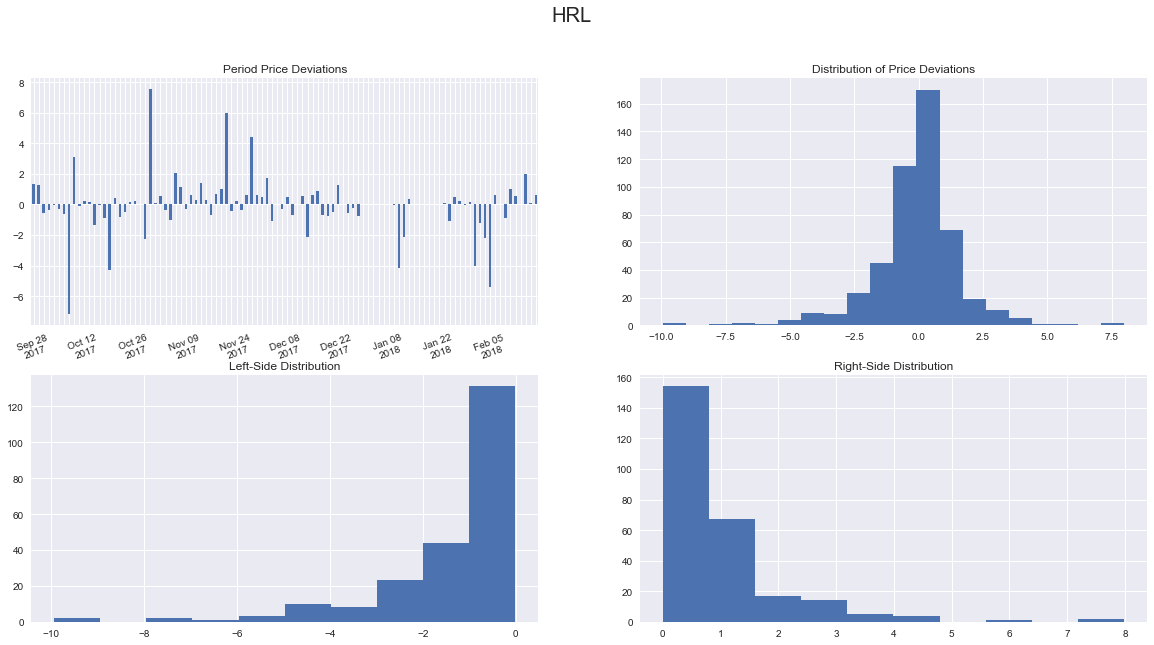

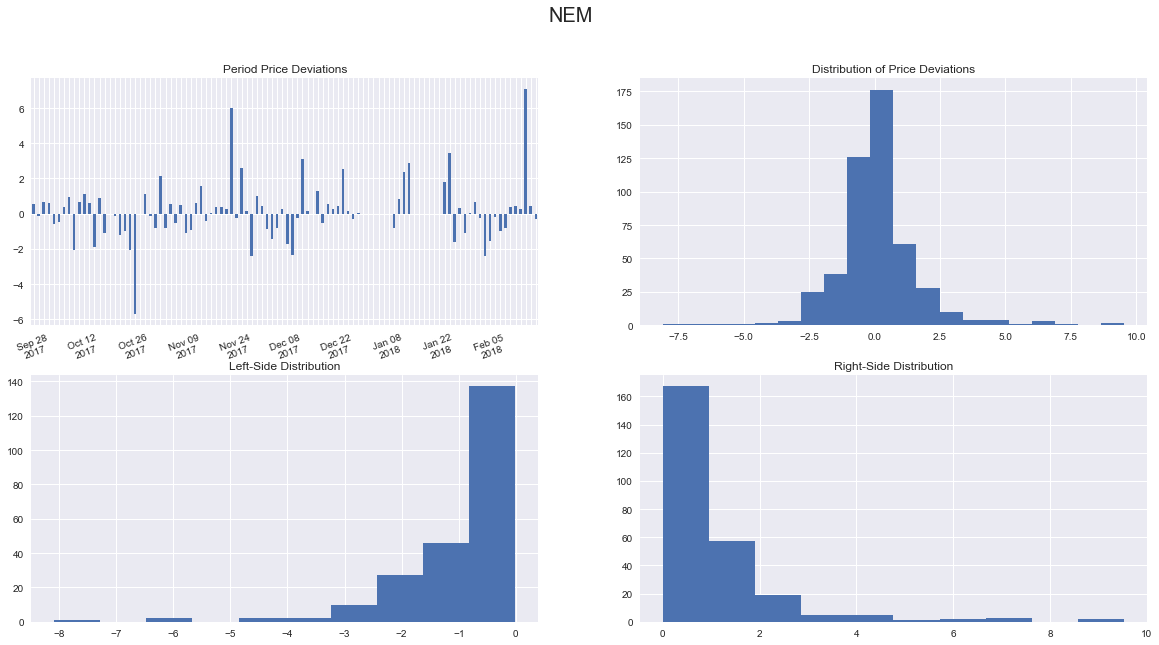

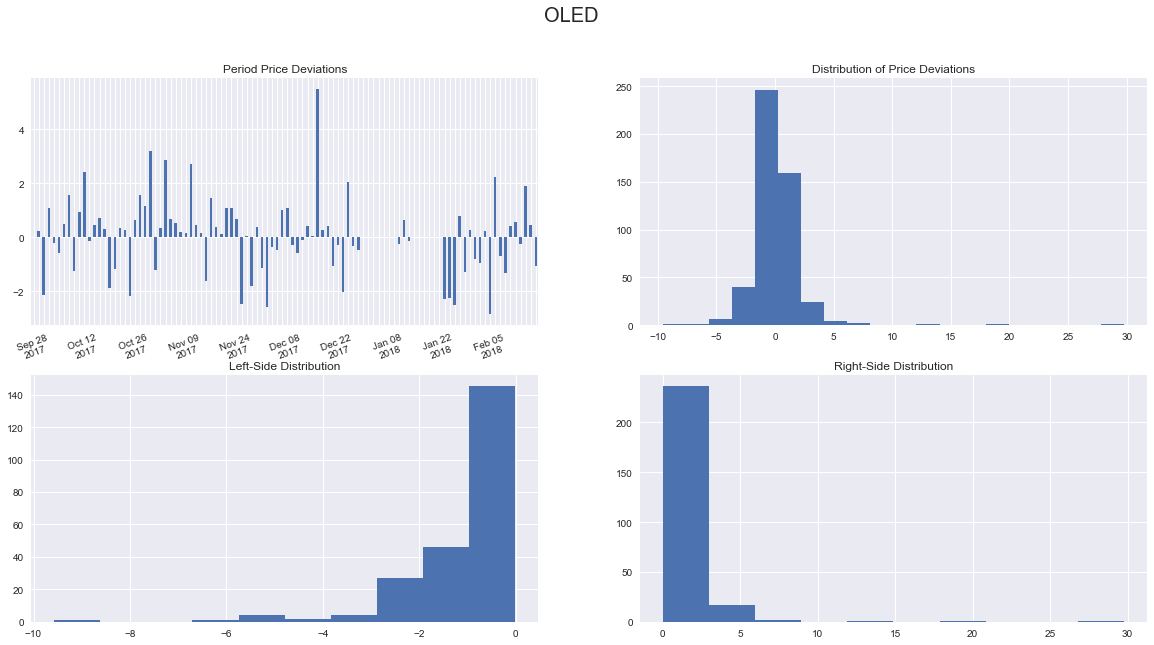

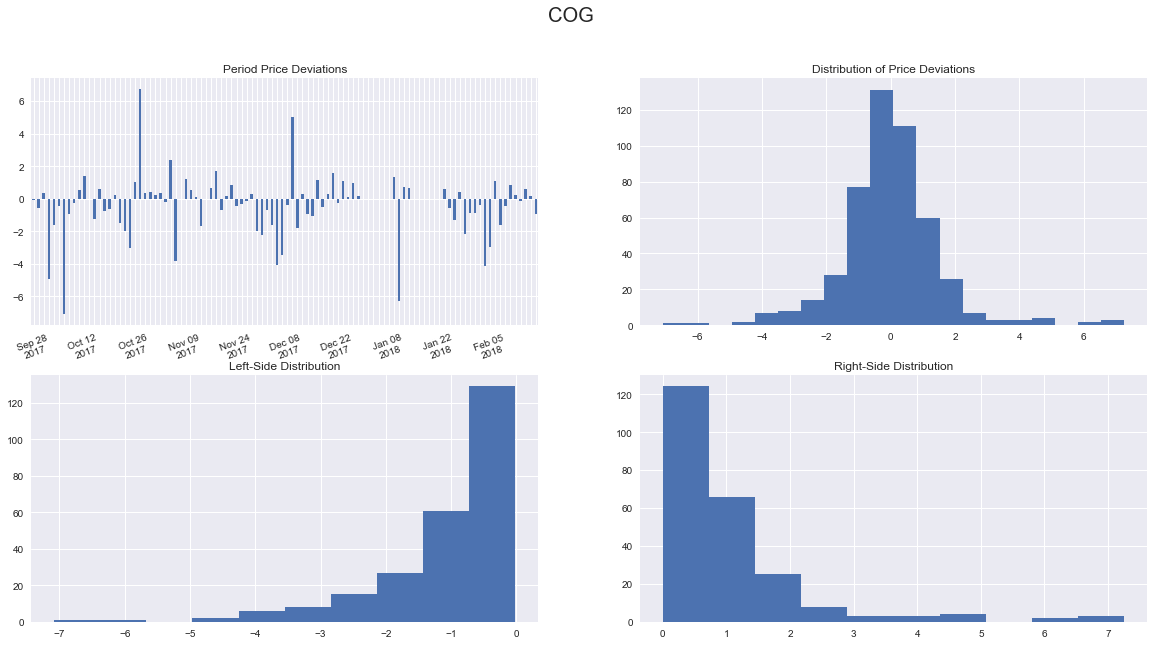

In [6]:
rolling_period = 4
lookback_window = 100
hist_window = 500
for ticker in tickers:
    stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

In [4]:
dic = {}
clse = []
tkers = []
for ticker in tickers:
    clse = clse + [close[[ticker]].iloc[-1][ticker]]
    tkers = tkers + [ticker]
    
dic['Close'] = clse
dic['Ticker'] = tkers
pd.DataFrame(dic)

,Close,Ticker
0,25.430000,MOS
1,34.110001,DVN
2,186.970001,HD
3,34.470001,MGM
4,83.309998,MDT
5,57.639999,LNG
6,53.330002,CLR
7,16.760000,ETE
8,65.209999,GRMN
9,4.100000,NE


In [14]:
full_df['price_dev'].dropna().skew()

0.75157125093740373

In [15]:
full_df['price_dev'].dropna().describe()

count    2605.000000
mean        0.057219
std         1.819942
min       -11.782973
25%        -0.655835
50%         0.013202
75%         0.782285
max        24.518553
Name: price_dev, dtype: float64

In [28]:
std_thresh = 4

down_nums = summary[summary.index <= -std_thresh].sum()
up_nums = summary[summary.index >= std_thresh].sum()

print("Threshold stdev: {0} \nNumber of deviations downward: {1} \nNumber of deviations upward: {2}".format(std_thresh,
                                                                                                           down_nums,
                                                                                                           up_nums))

Threshold stdev: 4 
Number of deviations downward: Frequency    7
dtype: int64 
Number of deviations upward: Frequency    10
dtype: int64


In [16]:
full_df.to_csv('avgo.csv')

In [19]:
min(summary[summary['Frequency'] != 0].index) <= -10

True